In [1]:
import os
import pathlib
import numpy as np
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
# Define the directory of the dataset
data_dir = pathlib.Path('CatsDogs/')

# Collects the path of all the files within the dataset
data_paths = [str(path) for path in list(data_dir.glob("*/*.jpg"))]
print(f"Images in the dataset: {len(data_paths)}")

Images in the dataset: 24997


In [ ]:
# Convert non-jpeg images into jpeg files
formats = [(path, Image.open(path).format) for path in data_paths]
non_jpegs = list(filter(lambda x: x[1]!='JPEG', formats))
for path, _ in non_jpegs:
    img = Image.open(path)
    img.convert('RGB').save(path, format='JPEG')

In [3]:
# Create the respective tf.data.Dataset object
dataset = tf.data.Dataset.from_tensor_slices(data_paths)
# Shuffle the dataset
dataset = dataset.shuffle(len(data_paths), reshuffle_each_iteration=False)

2022-07-22 20:37:29.163939: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-22 20:37:29.269619: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-22 20:37:29.270436: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-22 20:37:29.272802: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [4]:
# Get the class names
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['Cats' 'Dogs']


In [5]:
# Create a test set
test_size = int(len(list(dataset)) * 0.2)
train = dataset.skip(test_size)
test = dataset.take(test_size)

# Create a validation set
val_size = int(len(list(train)) * 0.2)
val = train.take(val_size)
train = train.skip(val_size)

In [6]:
# Set initial params for the loader
batch_size = 64
img_height = 256
img_width = 256

In [7]:
def get_label(file_path):
    # Convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    one_hot = parts[-2] == class_names
    # Integer encode the label
    return tf.argmax(one_hot)

In [8]:
def decode_img(img):
    # Convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_jpeg(img, channels=3)
    # Resize the image to the desired size
    return tf.image.resize(img, [img_height, img_width])

In [9]:
def process_path(file_path):
    label = get_label(file_path)
    # Load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [10]:
# Create a dataset of image, label pairs
train = train.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
val = val.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
test = test.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)

In [11]:
# Configure dataset for performance
def configure_for_performance(ds):
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

train = configure_for_performance(train)
val = configure_for_performance(val)
test = configure_for_performance(test)

In [12]:
model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(8, 3, activation='relu', input_shape=(img_height, img_width, 3)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [13]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'])

In [14]:
n_epochs = 15

history = model.fit(
    train,
    validation_data=val,
    epochs=n_epochs
)

Epoch 1/15


2022-07-22 20:37:36.060988: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
2022-07-22 20:37:41.057049: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


 66/250 [======>.......................] - ETA: 43s - loss: 1.2820 - accuracy: 0.5384

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


 93/250 [==========>...................] - ETA: 37s - loss: 1.0997 - accuracy: 0.5607

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


110/250 [============>.................] - ETA: 33s - loss: 1.0267 - accuracy: 0.5771

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


184/250 [=====================>........] - ETA: 15s - loss: 0.8586 - accuracy: 0.6123

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


186/250 [=====================>........] - ETA: 15s - loss: 0.8558 - accuracy: 0.6129

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


203/250 [=======================>......] - ETA: 11s - loss: 0.8351 - accuracy: 0.6202

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


233/250 [==========================>...] - ETA: 4s - loss: 0.8037 - accuracy: 0.6315

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


250/250 [==============================] - ETA: 0s - loss: 0.7895 - accuracy: 0.6342

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


250/250 [==============================] - 83s 289ms/step - loss: 0.7895 - accuracy: 0.6342 - val_loss: 0.5721 - val_accuracy: 0.7054
Epoch 2/15


Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


 67/250 [=======>......................] - ETA: 24s - loss: 0.5531 - accuracy: 0.7225

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


 94/250 [==========>...................] - ETA: 21s - loss: 0.5414 - accuracy: 0.7307

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


110/250 [============>.................] - ETA: 19s - loss: 0.5370 - accuracy: 0.7342

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


184/250 [=====================>........] - ETA: 8s - loss: 0.5158 - accuracy: 0.7458

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


187/250 [=====================>........] - ETA: 8s - loss: 0.5157 - accuracy: 0.7457

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


204/250 [=======================>......] - ETA: 6s - loss: 0.5163 - accuracy: 0.7453

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


233/250 [==========================>...] - ETA: 2s - loss: 0.5133 - accuracy: 0.7485

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


249/250 [============================>.] - ETA: 0s - loss: 0.5109 - accuracy: 0.7509

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


250/250 [==============================] - 43s 163ms/step - loss: 0.5104 - accuracy: 0.7514 - val_loss: 0.5595 - val_accuracy: 0.7179
Epoch 3/15


Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


 67/250 [=======>......................] - ETA: 24s - loss: 0.4579 - accuracy: 0.7815

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


 93/250 [==========>...................] - ETA: 20s - loss: 0.4515 - accuracy: 0.7880

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


110/250 [============>.................] - ETA: 18s - loss: 0.4484 - accuracy: 0.7903

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


184/250 [=====================>........] - ETA: 8s - loss: 0.4320 - accuracy: 0.7983

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


187/250 [=====================>........] - ETA: 8s - loss: 0.4315 - accuracy: 0.7990

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


204/250 [=======================>......] - ETA: 6s - loss: 0.4284 - accuracy: 0.8019

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


234/250 [===========================>..] - ETA: 2s - loss: 0.4280 - accuracy: 0.8032

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


250/250 [==============================] - ETA: 0s - loss: 0.4276 - accuracy: 0.8027

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


250/250 [==============================] - 42s 162ms/step - loss: 0.4276 - accuracy: 0.8027 - val_loss: 0.6126 - val_accuracy: 0.6957
Epoch 4/15


Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


 66/250 [======>.......................] - ETA: 24s - loss: 0.3709 - accuracy: 0.8449

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


 94/250 [==========>...................] - ETA: 21s - loss: 0.3644 - accuracy: 0.8484

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


110/250 [============>.................] - ETA: 19s - loss: 0.3645 - accuracy: 0.8469

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


184/250 [=====================>........] - ETA: 8s - loss: 0.3509 - accuracy: 0.8545

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


187/250 [=====================>........] - ETA: 8s - loss: 0.3516 - accuracy: 0.8539

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


204/250 [=======================>......] - ETA: 6s - loss: 0.3482 - accuracy: 0.8555

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


234/250 [===========================>..] - ETA: 2s - loss: 0.3448 - accuracy: 0.8573

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


250/250 [==============================] - ETA: 0s - loss: 0.3456 - accuracy: 0.8568

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


250/250 [==============================] - 43s 165ms/step - loss: 0.3456 - accuracy: 0.8568 - val_loss: 0.6141 - val_accuracy: 0.7067
Epoch 5/15


Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


 66/250 [======>.......................] - ETA: 24s - loss: 0.3008 - accuracy: 0.8828

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


 93/250 [==========>...................] - ETA: 20s - loss: 0.2963 - accuracy: 0.8844

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


110/250 [============>.................] - ETA: 18s - loss: 0.2932 - accuracy: 0.8859

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


184/250 [=====================>........] - ETA: 8s - loss: 0.2834 - accuracy: 0.8904

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


187/250 [=====================>........] - ETA: 8s - loss: 0.2832 - accuracy: 0.8908

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


204/250 [=======================>......] - ETA: 6s - loss: 0.2826 - accuracy: 0.8912

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


233/250 [==========================>...] - ETA: 2s - loss: 0.2811 - accuracy: 0.8914

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


249/250 [============================>.] - ETA: 0s - loss: 0.2827 - accuracy: 0.8894

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


250/250 [==============================] - 42s 163ms/step - loss: 0.2828 - accuracy: 0.8894 - val_loss: 0.6714 - val_accuracy: 0.6892
Epoch 6/15


Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


 66/250 [======>.......................] - ETA: 23s - loss: 0.2392 - accuracy: 0.9122

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


 94/250 [==========>...................] - ETA: 20s - loss: 0.2390 - accuracy: 0.9102

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


110/250 [============>.................] - ETA: 18s - loss: 0.2415 - accuracy: 0.9092

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


184/250 [=====================>........] - ETA: 8s - loss: 0.2327 - accuracy: 0.9147

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


187/250 [=====================>........] - ETA: 8s - loss: 0.2319 - accuracy: 0.9154

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


203/250 [=======================>......] - ETA: 6s - loss: 0.2304 - accuracy: 0.9161

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


233/250 [==========================>...] - ETA: 2s - loss: 0.2289 - accuracy: 0.9167

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


249/250 [============================>.] - ETA: 0s - loss: 0.2283 - accuracy: 0.9171

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


250/250 [==============================] - 42s 162ms/step - loss: 0.2283 - accuracy: 0.9172 - val_loss: 0.7026 - val_accuracy: 0.7074
Epoch 7/15


Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


 66/250 [======>.......................] - ETA: 26s - loss: 0.1934 - accuracy: 0.9377

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


 94/250 [==========>...................] - ETA: 22s - loss: 0.1918 - accuracy: 0.9370

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


110/250 [============>.................] - ETA: 19s - loss: 0.1920 - accuracy: 0.9365

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


184/250 [=====================>........] - ETA: 9s - loss: 0.1799 - accuracy: 0.9426

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


187/250 [=====================>........] - ETA: 8s - loss: 0.1790 - accuracy: 0.9429

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


204/250 [=======================>......] - ETA: 6s - loss: 0.1786 - accuracy: 0.9432

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


233/250 [==========================>...] - ETA: 2s - loss: 0.1775 - accuracy: 0.9434

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


250/250 [==============================] - ETA: 0s - loss: 0.1791 - accuracy: 0.9423

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


250/250 [==============================] - 44s 168ms/step - loss: 0.1791 - accuracy: 0.9423 - val_loss: 0.7824 - val_accuracy: 0.6867
Epoch 8/15


Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


 66/250 [======>.......................] - ETA: 25s - loss: 0.1425 - accuracy: 0.9569

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


 94/250 [==========>...................] - ETA: 21s - loss: 0.1383 - accuracy: 0.9594

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


110/250 [============>.................] - ETA: 19s - loss: 0.1401 - accuracy: 0.9589

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


184/250 [=====================>........] - ETA: 8s - loss: 0.1355 - accuracy: 0.9605

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


187/250 [=====================>........] - ETA: 8s - loss: 0.1353 - accuracy: 0.9605

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


204/250 [=======================>......] - ETA: 6s - loss: 0.1352 - accuracy: 0.9607

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


234/250 [===========================>..] - ETA: 2s - loss: 0.1354 - accuracy: 0.9595

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


249/250 [============================>.] - ETA: 0s - loss: 0.1364 - accuracy: 0.9590

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


250/250 [==============================] - 43s 166ms/step - loss: 0.1364 - accuracy: 0.9591 - val_loss: 0.8541 - val_accuracy: 0.6857
Epoch 9/15


Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


 66/250 [======>.......................] - ETA: 25s - loss: 0.1017 - accuracy: 0.9759

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


 94/250 [==========>...................] - ETA: 21s - loss: 0.1027 - accuracy: 0.9747

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


110/250 [============>.................] - ETA: 19s - loss: 0.1025 - accuracy: 0.9759

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


183/250 [====================>.........] - ETA: 9s - loss: 0.0999 - accuracy: 0.9758

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


184/250 [=====================>........] - ETA: 9s - loss: 0.1000 - accuracy: 0.9757

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


187/250 [=====================>........] - ETA: 8s - loss: 0.0995 - accuracy: 0.9760

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


204/250 [=======================>......] - ETA: 6s - loss: 0.0992 - accuracy: 0.9756

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


234/250 [===========================>..] - ETA: 2s - loss: 0.0964 - accuracy: 0.9764

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


249/250 [============================>.] - ETA: 0s - loss: 0.0971 - accuracy: 0.9757

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


250/250 [==============================] - 43s 165ms/step - loss: 0.0974 - accuracy: 0.9754 - val_loss: 1.0030 - val_accuracy: 0.6849
Epoch 10/15


Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


 66/250 [======>.......................] - ETA: 24s - loss: 0.0841 - accuracy: 0.9834

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


 94/250 [==========>...................] - ETA: 20s - loss: 0.0791 - accuracy: 0.9844

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


110/250 [============>.................] - ETA: 18s - loss: 0.0809 - accuracy: 0.9827

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


184/250 [=====================>........] - ETA: 8s - loss: 0.0784 - accuracy: 0.9831

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


187/250 [=====================>........] - ETA: 8s - loss: 0.0780 - accuracy: 0.9832

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


204/250 [=======================>......] - ETA: 6s - loss: 0.0768 - accuracy: 0.9835

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


234/250 [===========================>..] - ETA: 2s - loss: 0.0746 - accuracy: 0.9840

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


249/250 [============================>.] - ETA: 0s - loss: 0.0744 - accuracy: 0.9837

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


250/250 [==============================] - 42s 162ms/step - loss: 0.0744 - accuracy: 0.9837 - val_loss: 1.0787 - val_accuracy: 0.6787
Epoch 11/15


Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


 67/250 [=======>......................] - ETA: 23s - loss: 0.0678 - accuracy: 0.9853

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


 93/250 [==========>...................] - ETA: 21s - loss: 0.0645 - accuracy: 0.9871

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


110/250 [============>.................] - ETA: 19s - loss: 0.0622 - accuracy: 0.9881

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


184/250 [=====================>........] - ETA: 8s - loss: 0.0585 - accuracy: 0.9885

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


187/250 [=====================>........] - ETA: 8s - loss: 0.0583 - accuracy: 0.9885

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


204/250 [=======================>......] - ETA: 6s - loss: 0.0571 - accuracy: 0.9888

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


234/250 [===========================>..] - ETA: 2s - loss: 0.0569 - accuracy: 0.9886

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


250/250 [==============================] - ETA: 0s - loss: 0.0566 - accuracy: 0.9887

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


250/250 [==============================] - 42s 162ms/step - loss: 0.0566 - accuracy: 0.9887 - val_loss: 1.1880 - val_accuracy: 0.6872
Epoch 12/15


Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


 66/250 [======>.......................] - ETA: 24s - loss: 0.0419 - accuracy: 0.9922

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


 94/250 [==========>...................] - ETA: 20s - loss: 0.0416 - accuracy: 0.9925

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


110/250 [============>.................] - ETA: 18s - loss: 0.0410 - accuracy: 0.9935

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


184/250 [=====================>........] - ETA: 8s - loss: 0.0386 - accuracy: 0.9941

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


187/250 [=====================>........] - ETA: 8s - loss: 0.0383 - accuracy: 0.9942

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


203/250 [=======================>......] - ETA: 6s - loss: 0.0387 - accuracy: 0.9939

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


233/250 [==========================>...] - ETA: 2s - loss: 0.0380 - accuracy: 0.9942

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


249/250 [============================>.] - ETA: 0s - loss: 0.0378 - accuracy: 0.9944

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


250/250 [==============================] - 42s 163ms/step - loss: 0.0378 - accuracy: 0.9944 - val_loss: 1.2849 - val_accuracy: 0.6854
Epoch 13/15


Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


 66/250 [======>.......................] - ETA: 24s - loss: 0.0334 - accuracy: 0.9941

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


 94/250 [==========>...................] - ETA: 20s - loss: 0.0331 - accuracy: 0.9945

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


110/250 [============>.................] - ETA: 18s - loss: 0.0331 - accuracy: 0.9946

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


184/250 [=====================>........] - ETA: 8s - loss: 0.0308 - accuracy: 0.9957

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


187/250 [=====================>........] - ETA: 8s - loss: 0.0308 - accuracy: 0.9957

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


204/250 [=======================>......] - ETA: 6s - loss: 0.0302 - accuracy: 0.9957

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


234/250 [===========================>..] - ETA: 2s - loss: 0.0293 - accuracy: 0.9959

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


249/250 [============================>.] - ETA: 0s - loss: 0.0292 - accuracy: 0.9959

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


250/250 [==============================] - 42s 163ms/step - loss: 0.0293 - accuracy: 0.9958 - val_loss: 1.3984 - val_accuracy: 0.6789
Epoch 14/15


Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


 66/250 [======>.......................] - ETA: 24s - loss: 0.0211 - accuracy: 0.9979

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


 94/250 [==========>...................] - ETA: 20s - loss: 0.0242 - accuracy: 0.9967

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


110/250 [============>.................] - ETA: 18s - loss: 0.0260 - accuracy: 0.9962

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


184/250 [=====================>........] - ETA: 9s - loss: 0.0251 - accuracy: 0.9966

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


187/250 [=====================>........] - ETA: 8s - loss: 0.0250 - accuracy: 0.9967

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


204/250 [=======================>......] - ETA: 6s - loss: 0.0245 - accuracy: 0.9968

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


233/250 [==========================>...] - ETA: 2s - loss: 0.0241 - accuracy: 0.9968

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


249/250 [============================>.] - ETA: 0s - loss: 0.0249 - accuracy: 0.9965

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


250/250 [==============================] - 42s 163ms/step - loss: 0.0249 - accuracy: 0.9966 - val_loss: 1.4816 - val_accuracy: 0.6887
Epoch 15/15


Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


 66/250 [======>.......................] - ETA: 24s - loss: 0.0178 - accuracy: 0.9981

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


 94/250 [==========>...................] - ETA: 21s - loss: 0.0181 - accuracy: 0.9982

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


110/250 [============>.................] - ETA: 19s - loss: 0.0175 - accuracy: 0.9984

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


184/250 [=====================>........] - ETA: 9s - loss: 0.0199 - accuracy: 0.9976

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


187/250 [=====================>........] - ETA: 8s - loss: 0.0198 - accuracy: 0.9977

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


204/250 [=======================>......] - ETA: 6s - loss: 0.0196 - accuracy: 0.9978

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


233/250 [==========================>...] - ETA: 2s - loss: 0.0208 - accuracy: 0.9973

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


249/250 [============================>.] - ETA: 0s - loss: 0.0211 - accuracy: 0.9970

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


250/250 [==============================] - 43s 164ms/step - loss: 0.0211 - accuracy: 0.9970 - val_loss: 1.7261 - val_accuracy: 0.6784


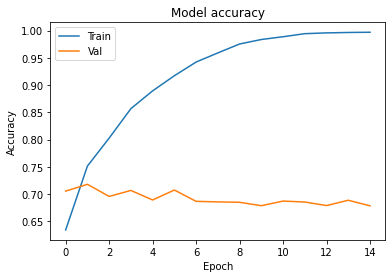

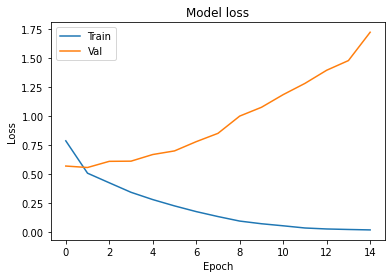

In [15]:
def plot_history(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

plot_history(history)

In [16]:
def zero_one_loss(dataset, dataset_size):
    
    _, accuracy = model.evaluate(dataset)
    zero_one_loss = dataset_size*(1-accuracy)

    return int(round(zero_one_loss, ndigits=0))

In [17]:
print(f"Zero-one loss on the test set: {zero_one_loss(test, test_size)}")

 8/79 [==>...........................] - ETA: 17s - loss: 1.8207 - accuracy: 0.6523

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


51/79 [==================>...........] - ETA: 6s - loss: 1.7766 - accuracy: 0.6636

79/79 [==============================] - 19s 192ms/step - loss: 1.7903 - accuracy: 0.6569
Zero-one loss on the test set: 1715


In [18]:
# Clear any previous state
del model
tf.keras.backend.clear_session()

# K-fold cross validation

In [19]:
from random import shuffle
from sklearn.model_selection import KFold


k_fold = KFold(n_splits=5)
k_splits = k_fold.split(data_paths)
results = []
zero_one_losses = []

for train_index, test_index in k_splits:

    # Get the paths to the data
    train_paths = np.asarray(data_paths)[train_index]
    test_paths = np.asarray(data_paths)[test_index]

    # Make it tf.data.Dataset
    train = tf.data.Dataset.from_tensor_slices(train_paths)
    test = tf.data.Dataset.from_tensor_slices(test_paths)
    
    # Shuffle the dataset
    train = train.shuffle(len(train))
    test = test.shuffle(len(test))

    # Get labels
    train = train.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
    test = test.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
    
    # Configure for performance
    train = configure_for_performance(train)
    test = configure_for_performance(test)

    # Create the model
    model = tf.keras.Sequential([
        tf.keras.layers.Rescaling(1./255),
        tf.keras.layers.Conv2D(8, 3, activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'])
    
    model.fit(
        train,
        epochs=n_epochs,
        verbose=0
    )
    
    zero_one_losses.append(zero_one_loss(test, len(test_index)))
    
    # Clear any previous state
    del model
    tf.keras.backend.clear_session()

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker

 4/79 [>.............................] - ETA: 9s - loss: 1.9235 - accuracy: 0.5664

12/79 [===>..........................] - ETA: 8s - loss: 2.1543 - accuracy: 0.5143

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


79/79 [==============================] - 11s 112ms/step - loss: 1.9792 - accuracy: 0.5586


Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9

 9/79 [==>...........................] - ETA: 9s - loss: 2.3947 - accuracy: 0.5087

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


24/79 [========>.....................] - ETA: 7s - loss: 2.4623 - accuracy: 0.5039

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


58/79 [=====================>........] - ETA: 2s - loss: 2.4391 - accuracy: 0.5027

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


79/79 [==============================] - 11s 119ms/step - loss: 2.4295 - accuracy: 0.5052


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marke

 7/79 [=>............................] - ETA: 9s - loss: 0.6931 - accuracy: 0.5290 

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


18/79 [=====>........................] - ETA: 8s - loss: 0.6931 - accuracy: 0.5061

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


28/79 [=========>....................] - ETA: 6s - loss: 0.6932 - accuracy: 0.4939

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


79/79 [==============================] - 11s 114ms/step - loss: 0.6931 - accuracy: 0.5003


Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0x

40/79 [==============>...............] - ETA: 5s - loss: 2.8898 - accuracy: 0.5328

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


79/79 [==============================] - 11s 115ms/step - loss: 2.9577 - accuracy: 0.5329


Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd

 3/79 [>.............................] - ETA: 10s - loss: 0.9789 - accuracy: 0.0000e+00

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


79/79 [==============================] - 10s 112ms/step - loss: 0.9789 - accuracy: 0.0000e+00


In [20]:
mean_loss = np.round(np.mean(zero_one_losses), decimals=0)
std_loss = np.round(np.std(zero_one_losses), decimals=0)
print(f'The mean of zero-one loss is {int(mean_loss)}, with a standard deviation of {int(std_loss)} missmatched samples')

The mean of zero-one loss is 2903, with a standard deviation of 1053 missmatched samples
